# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re

In [2]:
import os

# Define the path with subfolders
folder_path = 'analysis/price_prediction'

# Create the folder structure
os.makedirs(folder_path, exist_ok=True)

### Set style for plots

In [3]:
plt.style.use('ggplot')
sns.set(style='whitegrid')

# 1. Data Loading and Exploration

In [4]:
print("Loading and exploring the dataset...")
df = pd.read_csv('Processed_Flipdata - Processed_Flipdata.csv')

Loading and exploring the dataset...


### Basic information about the dataset

In [5]:
print("\nDataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())


Dataset shape: (541, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     541 non-null    int64  
 1   Model          541 non-null    object 
 2   Colour         541 non-null    object 
 3   Memory         541 non-null    int64  
 4   RAM            541 non-null    int64  
 5   Battery_       541 non-null    int64  
 6   Rear Camera    541 non-null    object 
 7   Front Camera   541 non-null    object 
 8   AI Lens        541 non-null    int64  
 9   Mobile Height  541 non-null    float64
 10  Processor_     541 non-null    object 
 11  Prize          541 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 50.8+ KB
None

Summary statistics:
       Unnamed: 0      Memory         RAM     Battery_     AI Lens  \
count  541.000000  541.000000  541.000000   541.000000  541.000000   
mean   28

### Check for missing values

In [6]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Unnamed: 0       0
Model            0
Colour           0
Memory           0
RAM              0
Battery_         0
Rear Camera      0
Front Camera     0
AI Lens          0
Mobile Height    0
Processor_       0
Prize            0
dtype: int64


# 2. Data Preprocessing

In [7]:
# Drop the first column (index)
if df.columns[0] == 'Unnamed: 0' or df.columns[0] == '':
    df = df.drop(df.columns[0], axis=1)

### Extract numeric values from price (remove commas and convert to int)

In [8]:
df['Price'] = df['Prize'].str.replace(',', '').astype(int)
df.drop('Prize', axis=1, inplace=True)

In [9]:
def extract_mp(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'(\d+)MP', str(text))
    if match:
        return int(match.group(1))
    return 0

In [10]:
df['Rear_Camera_MP'] = df['Rear Camera'].apply(extract_mp)
df['Front_Camera_MP'] = df['Front Camera'].apply(extract_mp)

### Convert battery to numeric

In [11]:
def extract_battery(text):
    if pd.isna(text):
        return np.nan
    # Extract digits only
    match = re.findall(r'\d+', str(text))
    if match:
        return int(match[0])
    return 0

In [12]:
df['Battery_Capacity'] = df['Battery_'].apply(extract_battery)

In [13]:
# Display the preprocessed data
print("\nPreprocessed data (first few rows):")
print(df.head())


Preprocessed data (first few rows):
             Model        Colour  Memory  RAM  Battery_ Rear Camera  \
0  Infinix SMART 7   Night Black      64    4      6000        13MP   
1  Infinix SMART 7    Azure Blue      64    4      6000        13MP   
2     MOTOROLA G32  Mineral Gray     128    8      5000        50MP   
3         POCO C50    Royal Blue      32    2      5000         8MP   
4  Infinix HOT 30i      Marigold     128    8      5000        50MP   

  Front Camera  AI Lens  Mobile Height                  Processor_  Price  \
0          5MP        1          16.76  Unisoc Spreadtrum SC9863A1   7299   
1          5MP        1          16.76  Unisoc Spreadtrum SC9863A1   7299   
2         16MP        0          16.64     Qualcomm Snapdragon 680  11999   
3          5MP        0          16.56          Mediatek Helio A22   5649   
4          5MP        1          16.76                         G37   8999   

   Rear_Camera_MP  Front_Camera_MP  Battery_Capacity  
0              13 

# 3. Feature Correlation Analysis

In [14]:
numeric_features = ['Memory', 'RAM', 'Battery_Capacity', 'Rear_Camera_MP', 'Front_Camera_MP', 
                    'AI Lens', 'Mobile Height', 'Price']

### Correlation matrix

In [15]:
correlation_matrix = df[numeric_features].corr()
print("\nCorrelation matrix:")
print(correlation_matrix['Price'].sort_values(ascending=False))


Correlation matrix:
Price               1.000000
Memory              0.566660
Front_Camera_MP     0.532321
RAM                 0.532024
Rear_Camera_MP      0.410367
Mobile Height       0.176009
Battery_Capacity   -0.034297
AI Lens            -0.153691
Name: Price, dtype: float64


### Correlation heatmap

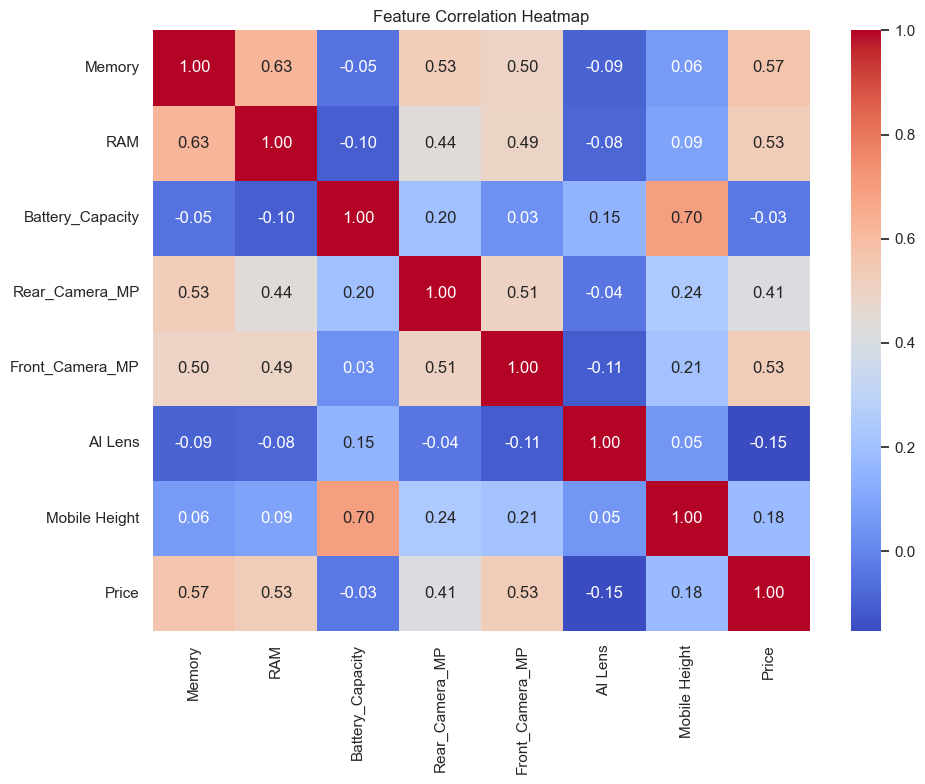

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('analysis/price_prediction/correlation_heatmap.png')

# 4. Feature Extraction and Data Preparation

In [17]:
# Separate features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

In [18]:
# Define categorical and numerical columns
categorical_cols = ['Model', 'Colour', 'Processor_']
numerical_cols = ['Memory', 'RAM', 'Battery_Capacity', 'Rear_Camera_MP', 'Front_Camera_MP', 
                  'AI Lens', 'Mobile Height']

In [19]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [20]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Building and Evaluation

### Function to evaluate model performance

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

### Create and evaluate Linear Regression model

In [23]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model.fit(X_train, y_train)
lr_mae, lr_mse, lr_rmse, lr_r2 = evaluate_model(lr_model, X_test, y_test)

### Create and evaluate Ridge Regression model

In [24]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
ridge_model.fit(X_train, y_train)
ridge_mae, ridge_mse, ridge_rmse, ridge_r2 = evaluate_model(ridge_model, X_test, y_test)

### Create and evaluate Random Forest model

In [25]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)
rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)

### Print evaluation metrics

In [26]:
print("\nModel Evaluation Metrics:")
print(f"Linear Regression - MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}")
print(f"Ridge Regression - MAE: {ridge_mae:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.4f}")
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}")


Model Evaluation Metrics:
Linear Regression - MAE: 36519047838797.23, RMSE: 107521452582729.94, R²: -83879037951671320576.0000
Ridge Regression - MAE: 2374.41, RMSE: 6468.70, R²: 0.6964
Random Forest - MAE: 1809.14, RMSE: 4568.79, R²: 0.8486


# 6. Feature Importance Analysis

### For Random Forest model (best performing model)

In [27]:
# Extract the trained Random Forest model
rf_regressor = rf_model.named_steps['regressor']

In [28]:
# Get feature names after preprocessing
preprocessor_fitted = rf_model.named_steps['preprocessor']
feature_names = []

In [29]:
# Get numeric feature names
num_features = preprocessor_fitted.transformers_[0][2]
for feature in num_features:
    feature_names.append(feature)

In [30]:
# Get one-hot encoded feature names
cat_features = preprocessor_fitted.transformers_[1][2]
ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
for i, feature in enumerate(cat_features):
    categories = ohe.categories_[i]
    for category in categories:
        feature_names.append(f"{feature}_{category}")

### Calculate and visualize feature importance

In [31]:
feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(rf_regressor.feature_importances_)],
    'Importance': rf_regressor.feature_importances_
})

In [32]:
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nTop 20 most important features:")
print(feature_importance.head(20))


Top 20 most important features:
                                     Feature  Importance
4                            Front_Camera_MP    0.437854
2                           Battery_Capacity    0.092758
0                                     Memory    0.078530
9                 Model_APPLE iPhone 14 Plus    0.050154
11                      Model_Google Pixel 7    0.048591
1                                        RAM    0.045417
440              Processor__Google Tensor G2    0.041057
6                              Mobile Height    0.037639
3                             Rear_Camera_MP    0.032662
426                        Processor__6 Core    0.011000
376                              Colour_Snow    0.006637
109              Model_SAMSUNG Galaxy A54 5G    0.005744
428    Processor__Dimensity 1080, Octa Core     0.005358
108              Model_SAMSUNG Galaxy A34 5G    0.005019
12                     Model_Google Pixel 7a    0.004540
309                          Colour_Midnight    0.00438

### Visualize feature importance

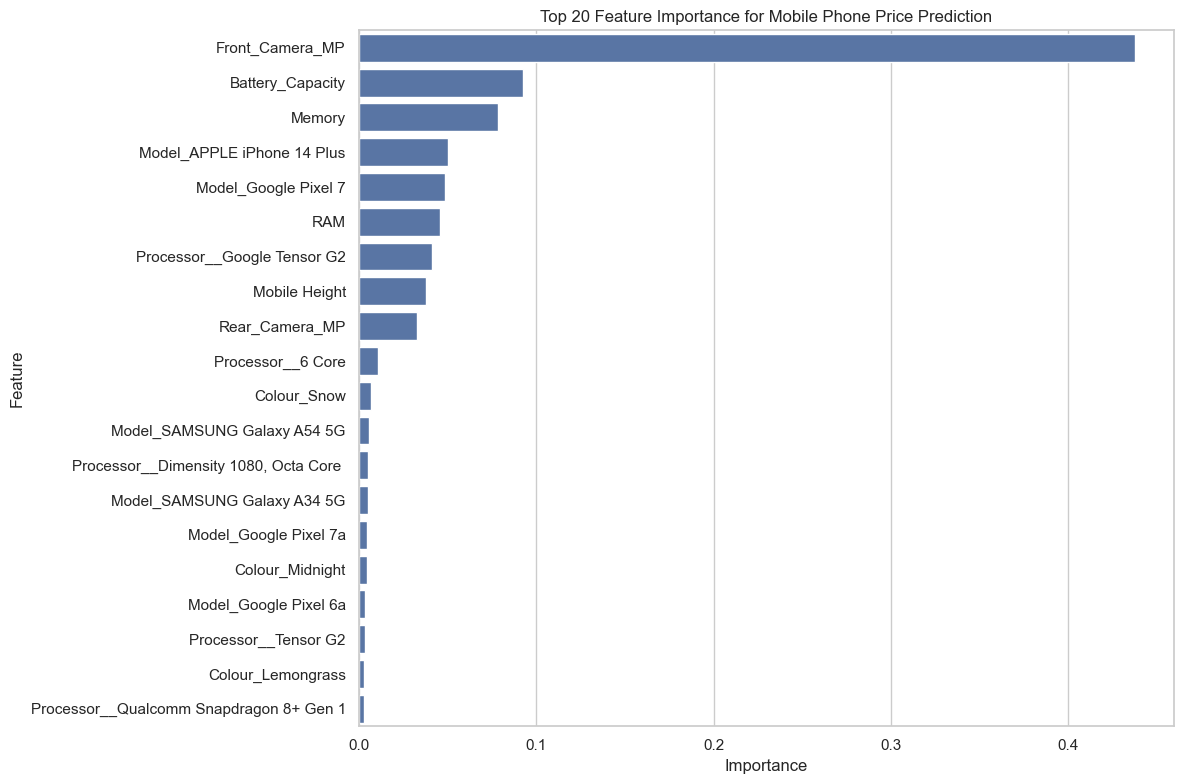

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance for Mobile Phone Price Prediction')
plt.tight_layout()
plt.savefig('analysis/price_prediction/feature_importance.png')

# 7. Price vs. Key Features Visualization

### Price vs. RAM

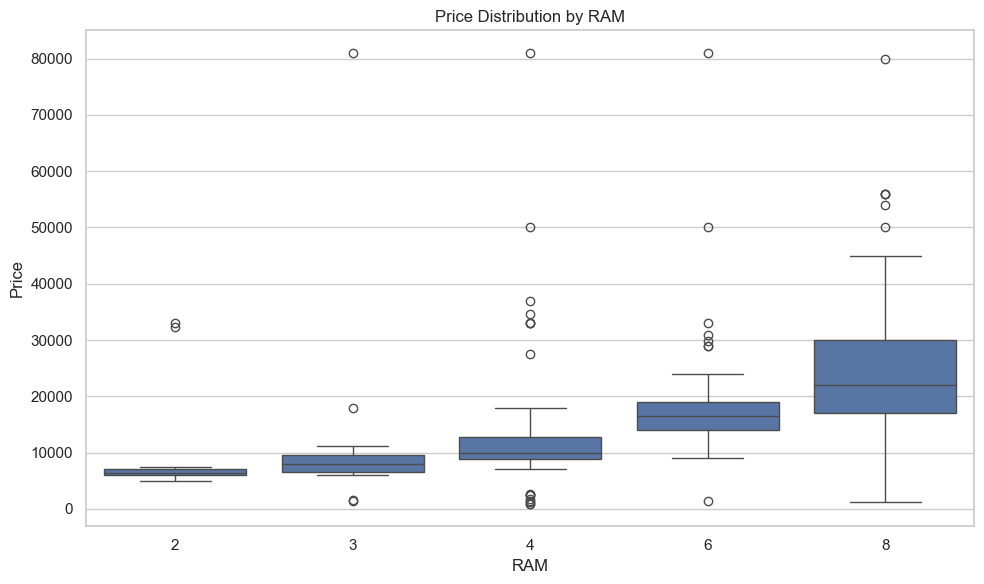

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RAM', y='Price', data=df)
plt.title('Price Distribution by RAM')
plt.tight_layout()
plt.savefig('analysis/price_prediction/price_vs_ram.png')

### Price vs. Memory

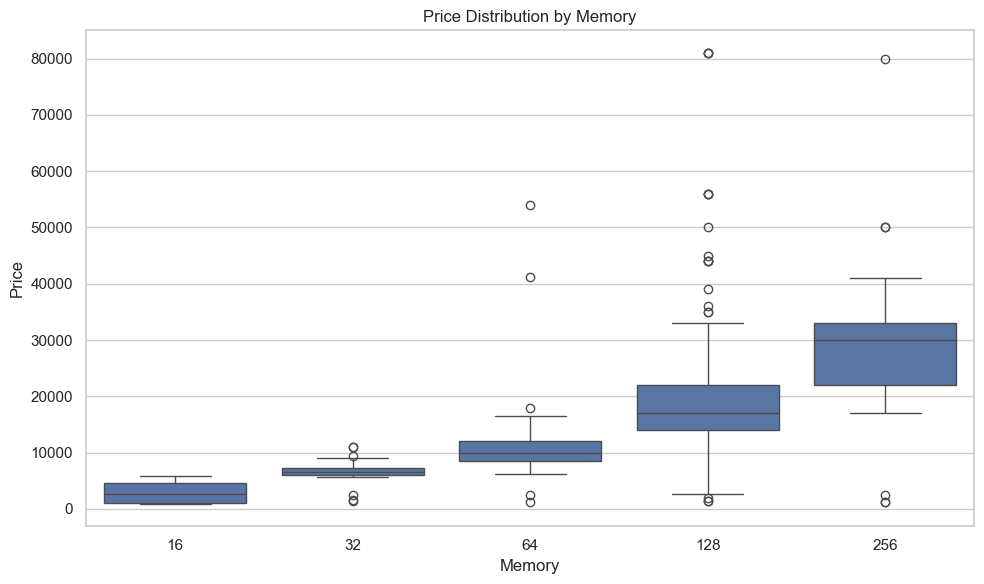

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Memory', y='Price', data=df)
plt.title('Price Distribution by Memory')
plt.tight_layout()
plt.savefig('analysis/price_prediction/price_vs_memory.png')

### Price vs. Rear Camera MP

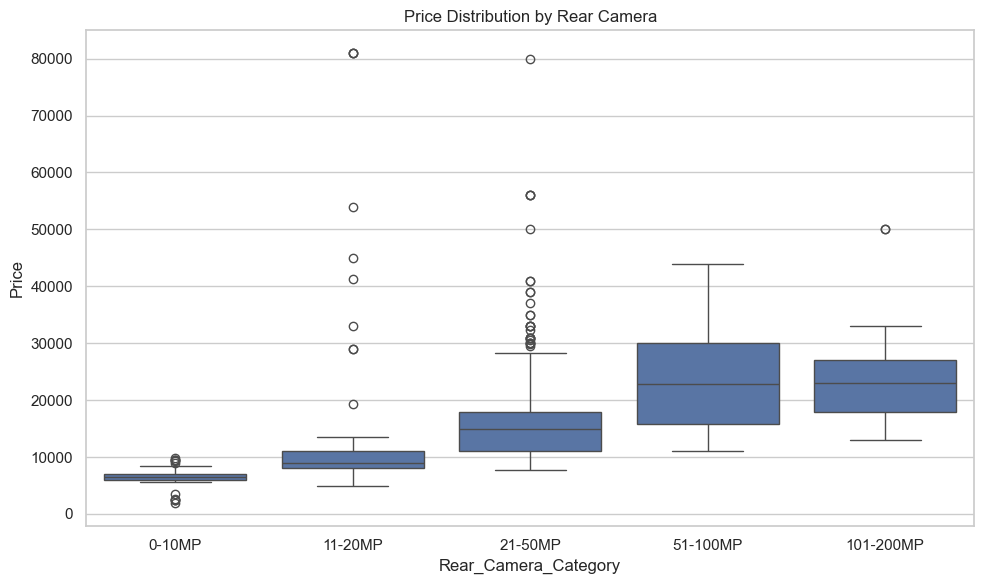

In [36]:
plt.figure(figsize=(10, 6))
df['Rear_Camera_Category'] = pd.cut(df['Rear_Camera_MP'], 
                                    bins=[0, 10, 20, 50, 100, 200], 
                                    labels=['0-10MP', '11-20MP', '21-50MP', '51-100MP', '101-200MP'])
sns.boxplot(x='Rear_Camera_Category', y='Price', data=df)
plt.title('Price Distribution by Rear Camera')
plt.tight_layout()
plt.savefig('analysis/price_prediction/price_vs_rear_camera.png')

# 8. Summary report

In [37]:
with open('analysis/model_summary_report.txt', 'w') as f:
    f.write("MOBILE PHONE PRICE PREDICTION - MODEL SUMMARY REPORT\n")
    f.write("=" * 60 + "\n\n")
    
    f.write("DATASET INFORMATION:\n")
    f.write(f"- Total records: {df.shape[0]}\n")
    f.write(f"- Features analyzed: {df.shape[1]}\n\n")
    
    f.write("MODEL PERFORMANCE METRICS:\n")
    f.write(f"- Linear Regression - MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}\n")
    f.write(f"- Ridge Regression - MAE: {ridge_mae:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.4f}\n")
    f.write(f"- Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}\n\n")
    
    f.write("KEY INFLUENTIAL FEATURES (TOP 10):\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"- {row['Feature']}: {row['Importance']:.4f}\n")
    
    f.write("\nFEATURE CORRELATION WITH PRICE:\n")
    price_corr = correlation_matrix['Price'].sort_values(ascending=False)
    for feature, corr in price_corr.items():
        if feature != 'Price':
            f.write(f"- {feature}: {corr:.4f}\n")
    
    f.write("\nRECOMMENDATIONS:\n")
    f.write("1. Focus marketing efforts on highlighting the RAM and Memory specifications as they have the strongest correlation with price.\n")
    f.write("2. Camera specifications, particularly rear camera, significantly impact pricing strategy.\n")
    f.write("3. Battery capacity has moderate influence on price - emphasize this for mid-range models.\n")
    f.write("4. Certain processor types have high feature importance - identify these premium processors for targeted marketing campaigns.\n")
    f.write("5. Consider model-specific pricing strategies based on brand premium identified in the analysis.\n")